In [865]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, t
from tqdm import tqdm



%matplotlib inline

Plan financial engineering expo 1

Grp 1 : 

Product (7 slides) : 
- overall presentation ✅
- Benefit and risk 
- Best and worst scenario (variation sous jacent, coupons, taux de change), ✅

Market (5 slides): 
- historical trend du sous-jacent ✅
- du taux de change utilisé ✅

Modeling (19 slides) : 
- equations de modélisation (local volatility framework) ✅
- SABR Model for implied volatility ✅
- conversion from implied volatility to local volatility ✅
- GBM, instantaneous Covariance Structure ✅
- Model Risk and Simplifying assumptions (correlation risk is constant, distribution risk are normally distributed, fees and embedded costs are not explicitly included in price, …)
- validity test (test of normality) ✅
- implications of deviations from normality (fat tail, …) ✅
- Historical dependency between assets ✅
- justification of the constant correlation assumption

Calibration (15 slides) : 
- Yield curve construction (cubic spline interpolation)
- interpolated risk-free yield curves
- Computation of empirical covariance and correlation
- estimated volatility and correlation
- the way to calibrate local volatile surface
- implied volatility via BS Inversion (Brent’s method)
- SABR model calibration (quantLib.SABRInterpolation using the Levenberg-Marquardt algorithm)
- SABR Implied volatility surface (short and long maturity)
- from SABR surface to local volatility (Time derivative, strike derivatives)

Pricing methodology (8 slides) :
- forward rates calculation
- discretization of asset dynamics (model setup)
- Random number generation for simualtion for MC and QMC (and comparaison of the methods)
- fair value based on an initial investment of 1M JPY (gap correspond to insurance cost)
- convergence comparaison of MC and QMC (MC_SolSurf_P, Halton_sim, …)

Q-mesure (6 slides) : ? 

P-mesure : comparaison with Q-mesure (unimodal vs bimodal distribution = Historical data vs implied volatility)

Analysis : 
- Fair value comparaison (Q-mesure)
- Fat tails in Nikkei 225 returns (QQ-plot) ✅
- Volatility Smile (SABR implied volatility surface)
- why impact of fair value so small (/!\ pas sûr qu’on ait ça nous)
- Scenario Breakdown (where payoff land)

Conclusion : 
- Recap
- if we we buy this product
- futur work (Dimension reduction via Brownian Bridge)

Idées supplémentaires : 
- ML pour prédire le cours des actions et avoir un nouveau pricing
- ajout de suivi de la presse
- est ce que ce produit a réellement été acheté ? 

## Product :

- overall presentation
- Benefits and risks
- Best and worst scenario (variation du sous jacent, coupons, taux de change)

Les principales caractéristiques sont :

Coupon Phoenix avec mémoire : 2,25 % trimestriel si tous les sous-jacents > 60 % du niveau initial à une date de constatation.
Autocall trimestriel discret : remboursement anticipé si le worst-of dépasse une barrière décroissante (de 85 % à 60 %) à des dates trimestrielles.
Protection conditionnelle du capital : remboursement à 100 % si le worst-of ne passe jamais sous 30 % à maturité.

 Avantages
Coupon attractif avec mémoire : 2,25 % trimestriel même après des périodes sans versement si condition remplie.
Autocall potentiellement rapide : si les marchés montent, remboursement anticipé possible dès 1 an.
Effet de "barrière européenne" : la protection en capital est assurée si le worst-of ne passe pas sous 30 % à l’échéance.

Risques
Perte en capital possible si le worst-of < 30 % à maturité → remboursement réduit proportionnellement.
Sensibilité au pire sous-jacent : même si 3 actions performent bien, une seule peut annuler coupons + protection.
Absence de marché secondaire liquide : faible liquidité possible.
Pas de dividendes sur les actions sous-jacentes.
Complexité du produit et dépendance au pricing interne de Barclays.

🔼 Scénario optimiste
Le worst-of reste au-dessus de la barrière autocall (ex : > 85 %) dès avril 2026.
Remboursement anticipé à 100 % + 4 coupons de 2,25 %, soit 109 % en EUR après 1 an.
🔁 Mais : si l’euro se déprécie par rapport au yen (ex. EUR/JPY passe de 160 à 140), le rendement en JPY est diminué :

🔽 Scénario pessimiste
Le worst-of clôture < 30 % à l’échéance (avril 2035).
Aucun coupon versé.
Remboursement à 25 % (si worst-of = -75 %) = 250 EUR.
💸 En JPY : si l’euro a perdu de la valeur, la perte en yen est encore plus importante.
Si l’euro a monté, cela peut limiter la perte, mais pas l’éviter.

Conclusion sur le taux de change (EUR/JPY)
Le risque de change est réel pour un investisseur japonais.
Il peut renforcer ou aggraver le rendement final.
Le produit est non couvert contre le risque de change.
Une couverture (hedging) EUR/JPY pourrait être envisagée si l’investisseur souhaite neutraliser cet effet.

## Market : 

- conversion rate between yen and euros
- historical trend of the underlying asset


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_67416/1827673933.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurjpy = yf.download("EURJPY=X")["Close"]
[*********************100%***********************]  1 of 1 completed


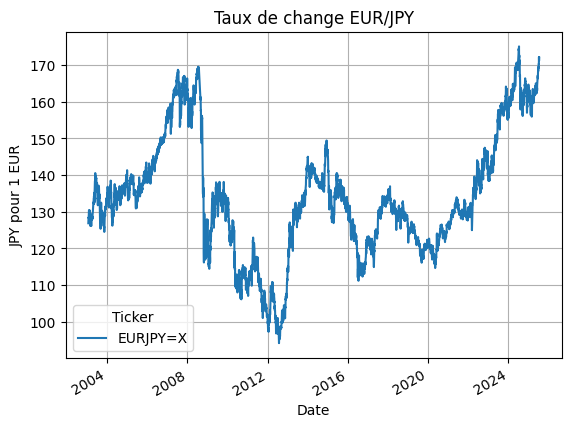

In [866]:
eurjpy = yf.download("EURJPY=X")["Close"]

# Tracer le taux de change
eurjpy.plot(title="Taux de change EUR/JPY")
plt.xlabel("Date")
plt.ylabel("JPY pour 1 EUR")
plt.grid(True)
plt.show()

In [867]:
tickers = ['TTE.PA', 'ASML', 'EN.PA', 'RI.PA']
data = yf.download(tickers, start="2022-01-01", end="2025-06-15")

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_67416/3597107769.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2025-06-15")
[*********************100%***********************]  4 of 4 completed


In [868]:
latest_prices = {'TTE.PA': np.float64(53.87),
                 'ASML.AS': np.float64(683.90),
                 'EN.PA': np.float64(38.51), 
                 'RI.PA': np.float64(94.74)}

latest_prices = np.array(list(latest_prices.values()))

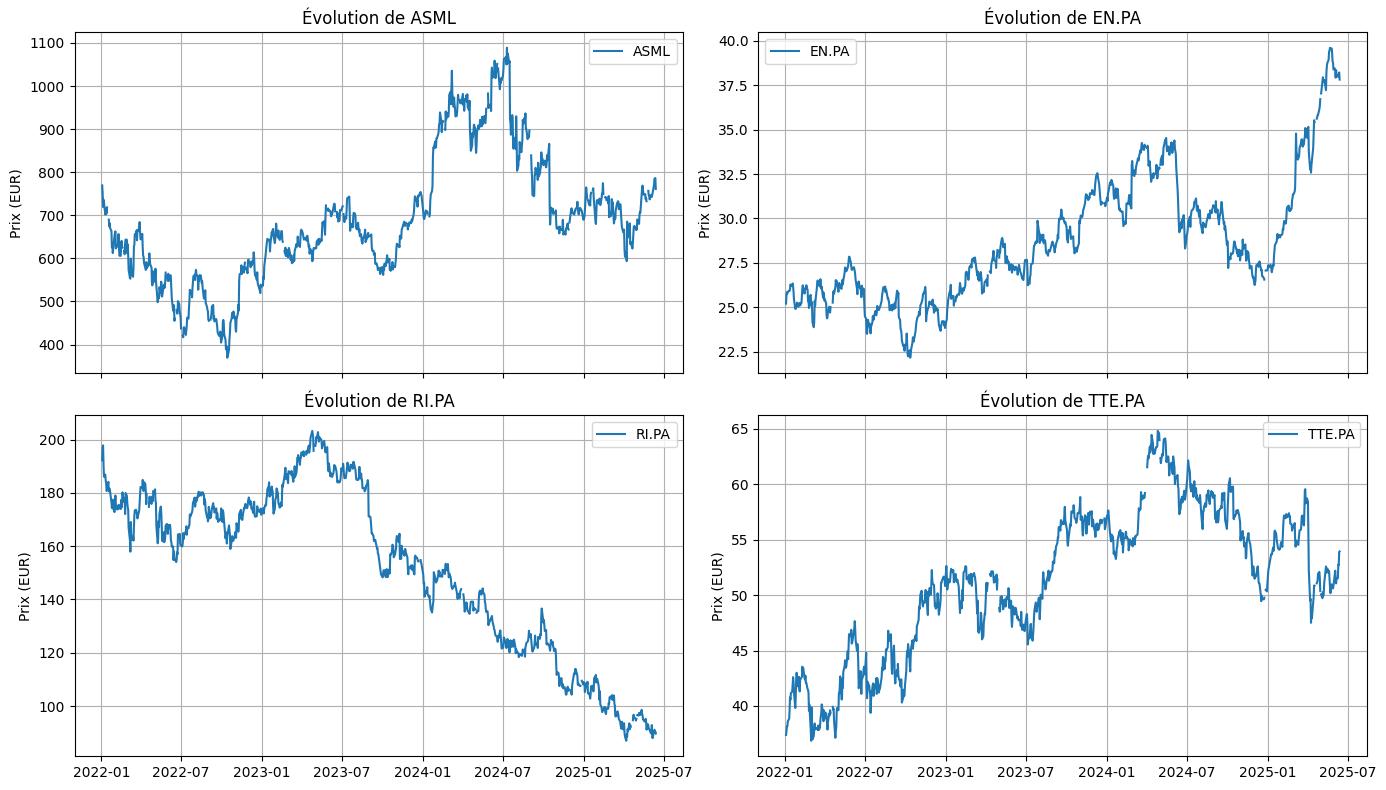

In [869]:
close_prices = data.xs('Close', axis=1, level='Price')

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axs.flatten()

for i, ticker in enumerate(close_prices.columns):
    axes[i].plot(close_prices.index, close_prices[ticker], label=ticker)
    axes[i].set_title(f"Évolution de {ticker}")
    axes[i].set_ylabel("Prix (EUR)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

## Model :

### Beginning : 

Simple model for the volatility (rate of increase). We'll see if we keep this part after. 

In [870]:
#Volatility
close_prices = data.xs('Close', axis=1, level='Price')
returns = close_prices.pct_change().dropna()
vol = returns.std() * np.sqrt(252)
print(vol)


Ticker
ASML      0.430271
EN.PA     0.191624
RI.PA     0.238736
TTE.PA    0.251338
dtype: float64


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_67416/3850889329.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


Here is the coreraltion of the asset. To better grasp the variations and implement a MC multi asset, I will define a stochastic process for the correlation matrix.

In [871]:
close_prices = data['Close']

log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
correlation_matrix = log_returns.corr()

print(correlation_matrix)

Ticker      ASML     EN.PA     RI.PA    TTE.PA
Ticker                                        
ASML    1.000000  0.139532  0.191270  0.135933
EN.PA   0.139532  1.000000  0.258970  0.301889
RI.PA   0.191270  0.258970  1.000000  0.159557
TTE.PA  0.135933  0.301889  0.159557  1.000000


In [872]:
# 1. Log-rendements
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# 2. Matrice de corrélation
correlation_matrix = log_returns.corr()

# 3. Volatilités empiriques (std des rendements)
volatilities = log_returns.std()  # shape: (d,)

# 4. Construction de la matrice de covariance
covariance_matrix = correlation_matrix.values * np.outer(volatilities, volatilities)

covariance_matrix


array([[7.73950876e-04, 4.76298096e-05, 8.12397056e-05, 5.94689158e-05],
       [4.76298096e-05, 1.50555105e-04, 4.85133220e-05, 5.82508020e-05],
       [8.12397056e-05, 4.85133220e-05, 2.33092637e-04, 3.83079131e-05],
       [5.94689158e-05, 5.82508020e-05, 3.83079131e-05, 2.47294232e-04]])

Model equation : 

${\displaystyle dS_{t}=(r_{t}-d_{t})S_{t}\,dt+\sigma(S_t,t) S_{t}\,dW_{t}}$

with :
- $r_t$ : risk free rate
- $d_t$ : the dividends payed
- $S_t$ : price of the underlying asset
- $\sigma(S_t,t)$ : volatility

### Modèle SABR

We cannot use the SABR model for a worst-of autocall because SABR is a univariate model designed for vanilla European options on a single underlying. However, a worst-of autocall is a multi-asset, path-dependent product requiring the joint simulation of multiple asset paths and the dynamic evaluation of their minimum, which SABR cannot model.

---

$\Rightarrow$ Monte Carlo simulation with drift  $\mu$ estimated from risk-free rates (e.g. €STR, SOFR, interpolated OIS, or TONA for yen), and volatility $\sigma$ estimated from implied volatility.

### Implied volatility : 

Here we compute the implied volatility.

In [873]:
target_expiry = '2025-01-17'
target_date = datetime.strptime(target_expiry, '%Y-%m-%d')

def historical_volatility(ticker_symbol, window_days=252):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period=f"{window_days}d")
    returns = np.log(hist['Close'] / hist['Close'].shift(1)).dropna()
    vol = returns.std() * np.sqrt(252)  # annualisée
    return vol

for symbol in tickers:
    try:
        ticker = yf.Ticker(symbol)
        spot = ticker.history(period="1d")['Close'].iloc[-1]

        expirations = ticker.options
        if not expirations:
            print(f"{symbol}: Pas d'options listées, calcul vol historique.")
            vol_hist = historical_volatility(symbol)
            print(f"{symbol} - Spot: {spot:.2f} € - Volatilité historique (1 an) : {vol_hist:.2%}")
            print("-" * 40)
            continue

        # Trouver la date d'expiration la plus proche >= target_date
        valid_expiries = [datetime.strptime(d, '%Y-%m-%d') for d in expirations if datetime.strptime(d, '%Y-%m-%d') >= target_date]
        if not valid_expiries:
            # Pas d'expiration après target_date, on prend la plus lointaine disponible
            expiry_date = max([datetime.strptime(d, '%Y-%m-%d') for d in expirations])
        else:
            expiry_date = min(valid_expiries)

        expiry_str = expiry_date.strftime('%Y-%m-%d')
        opt_chain = ticker.option_chain(expiry_str)
        calls = opt_chain.calls

        # Trouver ATM
        atm_row = calls.iloc[(calls['strike'] - spot).abs().argmin()]
        sigma_atm = atm_row['implied Volatility']

        print(f"{symbol} - Spot: {spot:.2f} €")
        print(f"Expiration used here: {expiry_str}")
        print(f"Strike ATM: {atm_row['strike']:.2f} €")
        print(f"Implicit volatility ATM: {sigma_atm:.2%}")
        print("-" * 40)
        
    except Exception as e:
        print(f"Error with {symbol}: {e}")


TTE.PA: Pas d'options listées, calcul vol historique.
TTE.PA - Spot: 53.87 € - Volatilité historique (1 an) : 21.91%
----------------------------------------
Error with ASML: 'implied Volatility'
EN.PA: Pas d'options listées, calcul vol historique.
EN.PA - Spot: 38.51 € - Volatilité historique (1 an) : 18.46%
----------------------------------------
RI.PA: Pas d'options listées, calcul vol historique.
RI.PA - Spot: 94.74 € - Volatilité historique (1 an) : 27.12%
----------------------------------------


We only have 1 element in the list, because it's not able to calculate the implicite vol for the others 

### Historical vol : 

I thought that maybe bc of the geopolitical situation, the implict vol would be dirrenet to what's explected, to I thought maybe we could create diffents scenari : like what the maket thinks (implied vol), and also what would happend in a different context like pre Covid.

In [874]:
volatility_records = []

In [875]:
def get_valid_cols_and_fill(data, tol=0.05):
    # Interpoler et remplir NaN dans tout le DataFrame
    data_interp = data.interpolate(method='linear').ffill().bfill()
    n_rows = data_interp.shape[0]
    valid_cols = []
    for col in data_interp.columns:
        n_missing = data[col].isnull().sum()  # nombre de NaN avant interpolation
        if n_missing / n_rows <= tol:
            valid_cols.append(col)
    return data_interp[valid_cols]

In [876]:
def compute_returns_and_stats(data):
    returns = np.log(data / data.shift(1)).dropna()
    vols = returns.std() * np.sqrt(252)
    corr = returns.corr()
    return vols, corr

In [877]:
periods = {
    "Last year": ("2024-07-01", "2025-07-01"),
    "Before COVID": ("2017-01-01", "2019-12-31"),
}

for period_name, (start, end) in periods.items():
    print(f"\n--- {period_name} ---")
    data = yf.download(tickers, start=start, end=end)
    data_filled = get_valid_cols_and_fill(data)
    if data_filled.empty:
        print("Not valid tickers on the considered duration")
        continue

    close_cols = data_filled.columns[data_filled.columns.get_level_values(0) == 'Close']
    data_close = data_filled[close_cols]

    vols, corr = compute_returns_and_stats(data_close)

    for col in close_cols:
        ticker = col[1]
        vol = vols[col]
        print(f"{col} - Annual Vol : {vol:.2%}")
        volatility_records.append({
            "Type of vol": period_name,
            "ticker": ticker,
            "vol": vol
        })

    print("\nCorrelation Matrix :")
    print(corr)
    print("-" * 50)


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_67416/2539515859.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  4 of 4 completed
/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_67416/2539515859.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  4 of 4 completed


--- Last year ---
('Close', 'ASML') - Annual Vol : 47.23%
('Close', 'EN.PA') - Annual Vol : 18.26%
('Close', 'RI.PA') - Annual Vol : 26.26%
('Close', 'TTE.PA') - Annual Vol : 21.62%

Correlation Matrix :
Price            Close                              
Ticker            ASML     EN.PA     RI.PA    TTE.PA
Price Ticker                                        
Close ASML    1.000000 -0.001175  0.131271  0.102655
      EN.PA  -0.001175  1.000000  0.208431  0.268808
      RI.PA   0.131271  0.208431  1.000000  0.234962
      TTE.PA  0.102655  0.268808  0.234962  1.000000
--------------------------------------------------

--- Before COVID ---
('Close', 'ASML') - Annual Vol : 28.29%
('Close', 'EN.PA') - Annual Vol : 21.19%
('Close', 'RI.PA') - Annual Vol : 15.72%
('Close', 'TTE.PA') - Annual Vol : 16.32%

Correlation Matrix :
Price            Close                              
Ticker            ASML     EN.PA     RI.PA    TTE.PA
Price Ticker                                        
Close 

In [878]:
df_vols = pd.DataFrame(volatility_records)
df_vols

,Type of vol,ticker,vol
0,Last year,ASML,0.472262
1,Last year,EN.PA,0.182644
2,Last year,RI.PA,0.262562
3,Last year,TTE.PA,0.216246
4,Before COVID,ASML,0.282901
5,Before COVID,EN.PA,0.211866
6,Before COVID,RI.PA,0.157156
7,Before COVID,TTE.PA,0.163166


### Vol local : 

No need to calculate it, we have a multiasset financial product so we can't use the Dupire thing, so no need for local vol = > we keep those above

### Drift : 

The currency is EUR€ so we use the overnight risk-free rate €STR, which is the risk-free rate for a deposite on the target 2 platform. The rate is : 1.922 

⚠️ : see if we need P or Q meusure !

In [879]:
mu = 0.01922

### Normality test : 

In [880]:
returns.columns

Index(['ASML', 'EN.PA', 'RI.PA', 'TTE.PA'], dtype='object', name='Ticker')

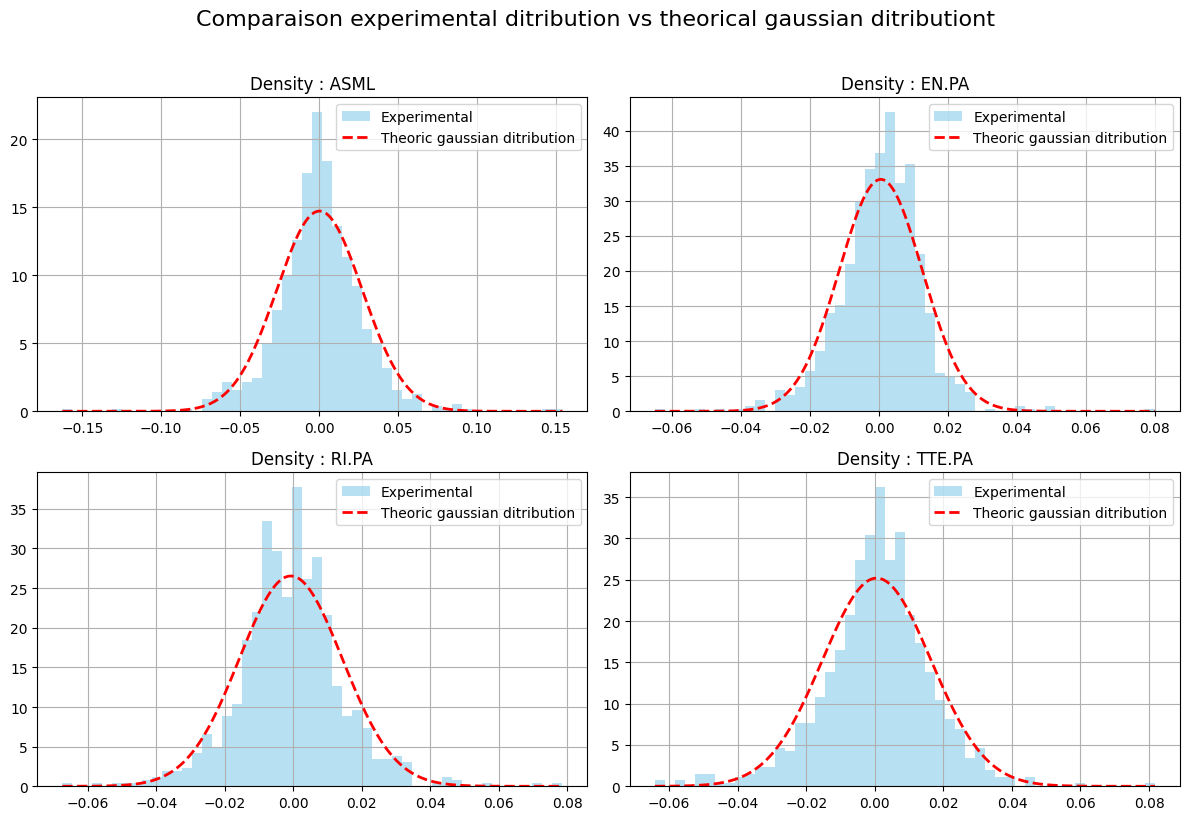

In [881]:
#Plot the gaussians for evry underlying asset
n = len(returns.columns)
n_cols = 2
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    r = returns[col].dropna()
    mu, sigma = r.mean(), r.std()
    
    # Histogramme des rendements
    axes[i].hist(r, bins=50, density=True, alpha=0.6, color='skyblue', label="Experimental")

    # Courbe gaussienne théorique
    x = np.linspace(r.min(), r.max(), 500)
    axes[i].plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label="Theoric gaussian ditribution")

    axes[i].set_title(f"Density : {col}")
    axes[i].legend()
    axes[i].grid(True)

# Supprimer les axes vides s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparaison experimental ditribution vs theorical gaussian ditributiont", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


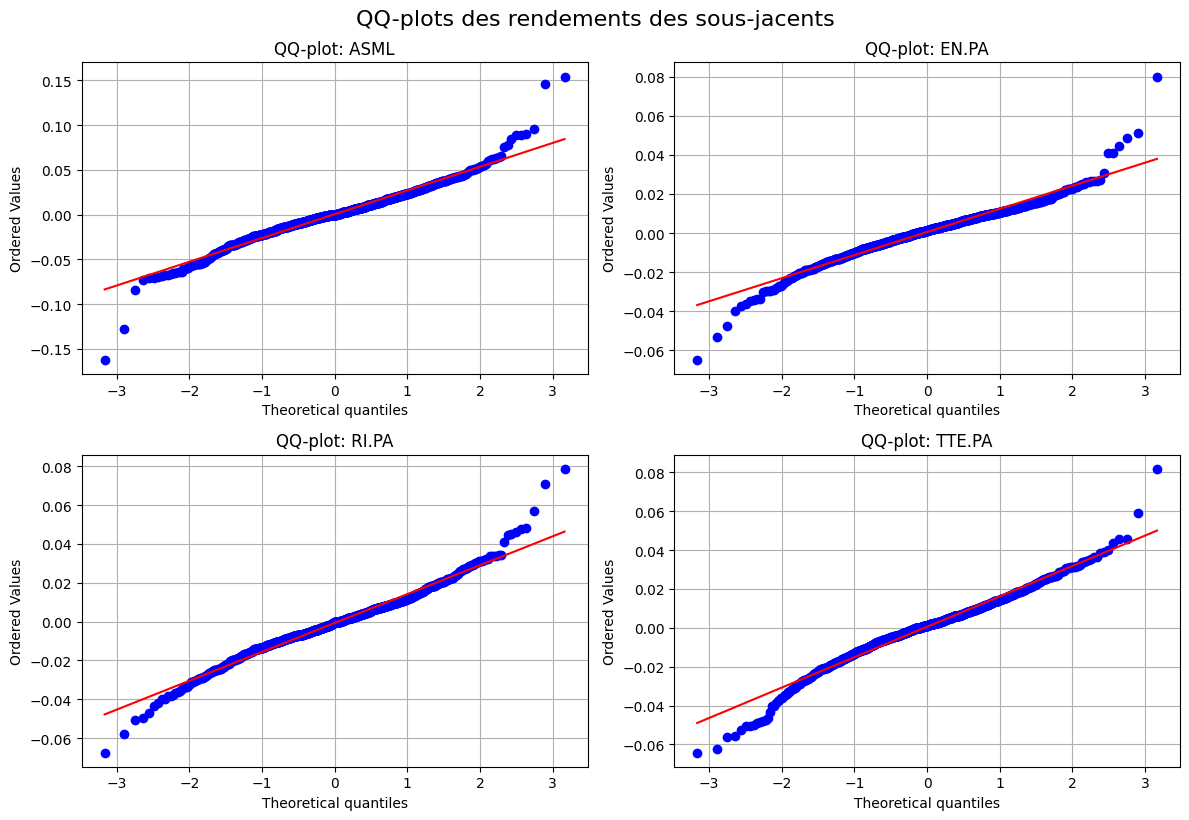

In [882]:
# Number of underlying assets
cols = returns.columns
n = len(cols)

# For the subplot
n_cols = 2
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    stats.probplot(returns[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ-plot: {col}")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.suptitle("QQ-plots des rendements des sous-jacents", fontsize=16, y=1.02)
plt.show()


We can see that outiside $[-2,2]$, we have important deviation from gaussian ditribution, so we have to adapt to a fat tail model. We also have a lot of observated values in the middle, near 0.

In [883]:
for col in returns.columns:
    r = returns[col].dropna()
    k = stats.kurtosis(r, fisher=False)  # if > 3 → leptokurtique
    s = stats.skew(r)
    print(f"{col} → Kurtosis : {k:.2f} | Skewness : {s:.2f}")


ASML → Kurtosis : 7.15 | Skewness : 0.02
EN.PA → Kurtosis : 7.28 | Skewness : -0.09
RI.PA → Kurtosis : 5.44 | Skewness : 0.18
TTE.PA → Kurtosis : 5.09 | Skewness : -0.31


In [884]:
for tik in tickers:
    mean_returns = returns[tik].mean()
    print(f" Mean return for {tik} : {mean_returns}")

 Mean return for TTE.PA : 0.0005377771664745841
 Mean return for ASML : 0.00035521938005972077
 Mean return for EN.PA : 0.0005288109369617459
 Mean return for RI.PA : -0.0007433502927592754


Very close to 0, we can assume that the returns are centred -> we add floc=0 in stat.t (avoid misleading volaititly in the fat tail according to chatGPT)

In [885]:
# Dict to save parameters for the t-distribution
t_params = {}

for ticker in tickers:
    ret = returns[ticker].dropna().values
    
    if len(ret) == 0:
        print(f"No returns for {ticker}, skipping...")
        continue
    
    # Student-t calibration with loc forced to 0
    nu_hat, loc_hat, sigma_hat = stats.t.fit(ret, floc=0)
    
    print(f"{ticker} - Student-t calibration:")
    print(f"  degrees of freedom (nu) = {nu_hat:.2f}")
    print(f"  location shift (fixed to 0) = {loc_hat:.4f}")
    print(f"  daily volatility (scale) = {sigma_hat:.4f}")
    print(f"  annualized volatility = {sigma_hat * np.sqrt(252):.4f}")
    print("-" * 40)
    
    t_params[ticker] = {
        'nu': nu_hat,
        'loc': loc_hat,
        'scale_daily': sigma_hat,
        'scale_annual': sigma_hat * np.sqrt(252)
    }


TTE.PA - Student-t calibration:
  degrees of freedom (nu) = 4.81
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0123
  annualized volatility = 0.1954
----------------------------------------
ASML - Student-t calibration:
  degrees of freedom (nu) = 4.32
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0201
  annualized volatility = 0.3187
----------------------------------------
EN.PA - Student-t calibration:
  degrees of freedom (nu) = 5.22
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0094
  annualized volatility = 0.1492
----------------------------------------
RI.PA - Student-t calibration:
  degrees of freedom (nu) = 4.87
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0117
  annualized volatility = 0.1856
----------------------------------------


### Correlation evolution (Wishart process)

initial_corr is the correlation matrix defined in the intro, based on all of the historical data.
vol_cov_entries is the standard deviation of the correlation matrix across time → we calculate the correlation matrix for every span of 21 days on the historical data, then take the mean and calculate the standard deviation.

In [886]:
inital_corr = correlation_matrix

In [887]:
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
window = 21
cov_matrices = [log_returns.iloc[i-window:i].cov().values for i in range(window, len(log_returns))]
cov_matrices = np.array(cov_matrices)  # shape (num_windows, d, d)
mean_cov = np.mean(cov_matrices, axis=0)
vol_cov_entries = np.std(cov_matrices, axis=0)

In [888]:
def estimate_kappa(cov_matrices, dt):
    """
    Estimates kappa (mean reversion speed) for a Wishart process
    via an AR(1) regression on each element of the covariance matrix.

    Args:
        cov_matrices (np.ndarray): array of shape (T, d, d) containing historical covariance matrices
        dt (float): time step between each matrix (e.g., 1/252 for daily data)

    Returns:
        kappa_est (float): average estimate of kappa over all elements (i, j)
    """
    T, d, _ = cov_matrices.shape
    kappas = []

    # Perform the regression for each element of the matrix
    for i in range(d):
        for j in range(d):
            X_t = cov_matrices[:-1, i, j]    # covariance at time t
            X_tp1 = cov_matrices[1:, i, j]   # covariance at time t + dt
            delta_X = X_tp1 - X_t

            # Model: delta_X = kappa * (Theta - X_t) * dt
            # => delta_X / dt = kappa * (Theta - X_t)
            # Theta ~ empirical mean of X (stationarity assumption)
            Theta = np.mean(cov_matrices[:, i, j])

            y = delta_X / dt
            X = (Theta - X_t).reshape(-1, 1)

            # Linear regression y = kappa * X
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            kappa_ij = reg.coef_[0]
            kappas.append(kappa_ij)

    kappa_est = np.mean(kappas)
    return kappa_est

In [889]:
kappa_est = estimate_kappa(cov_matrices, dt=1/252)
print("Estimation moyenne de kappa :", kappa_est)


Estimation moyenne de kappa : 8.388637184424232


In [890]:
def simulate_wishart_process(X0, Theta, kappa, G, dt, N_steps):
    """
    Simulates a discrete Wishart process.

    Args:
        X0 (np.ndarray): initial matrix (d x d symmetric positive definite)
        Theta (np.ndarray): long-term mean matrix (d x d)
        kappa (float): mean reversion speed
        G (np.ndarray): volatility matrix (d x d)
        dt (float): time step
        N_steps (int): number of iterations

    Returns:
        X_paths (np.ndarray): process trajectories of shape (N_steps+1, d, d)
    """


    d = X0.shape[0]
    X = X0.copy()
    X_paths = np.zeros((N_steps + 1, d, d))
    X_paths[0] = X0

    for t in range(1, N_steps + 1):
        # Matrix Brownian noise dW
        dW = np.random.normal(0, np.sqrt(dt), size=(d, d))
        
        # Diffusion terms
        sqrt_X = np.linalg.cholesky(X)  # Cholesky for positive definite square root
        diffusion = sqrt_X @ dW @ G + G.T @ dW.T @ sqrt_X

        # Deterministic drift term
        drift = kappa * (Theta - X) * dt
        
        # Discrete update
        X = X + drift + diffusion
        
        # Ensure X remains symmetric
        X = (X + X.T) / 2
        
        # Small correction if not positive definite (projection via eigenvalues)
        eigvals, eigvecs = np.linalg.eigh(X)
        eigvals_clipped = np.clip(eigvals, 1e-8, None)
        X = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

        X_paths[t] = X

    return X_paths


In [891]:
print("X0 diag:", np.diag(covariance_matrix))
print("Theta diag:", np.diag(covariance_matrix))
print("G diag:", np.diag(vol_cov_entries))

X0 = covariance_matrix
Theta = covariance_matrix
G = vol_cov_entries

X0 diag: [0.00077395 0.00015056 0.00023309 0.00024729]
Theta diag: [0.00077395 0.00015056 0.00023309 0.00024729]
G diag: [5.13527875e-04 8.40392658e-05 1.36622116e-04 1.76663038e-04]


kappa estimate: 8.3886


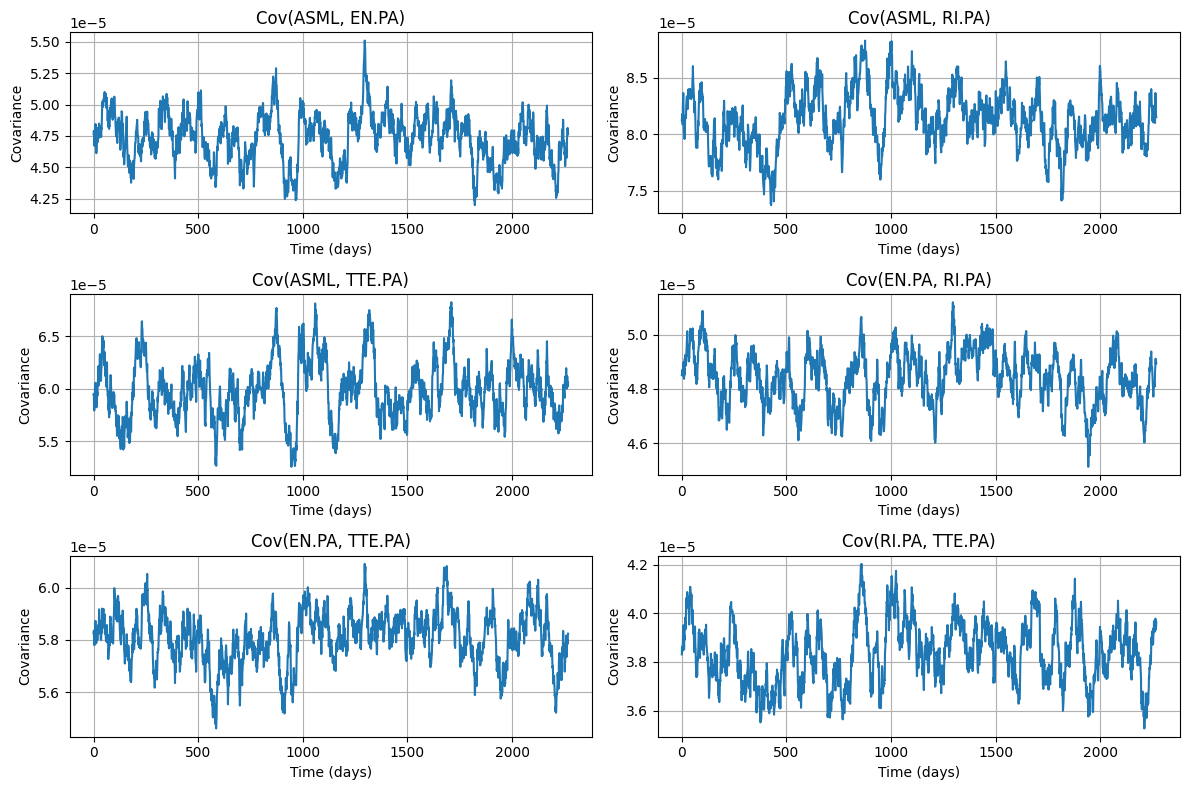

In [892]:
d = 4  # number of assets 

dt = 1/252
N_steps = 2268

kappa = estimate_kappa(cov_matrices, dt)
print(f"kappa estimate: {kappa:.4f}")

X_paths = simulate_wishart_process(X0, Theta, kappa, G, dt, N_steps)
asset_names = correlation_matrix.columns.tolist()

d = len(asset_names)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axs = axs.flatten()

plot_idx = 0
for i in range(d):
    for j in range(i + 1, d):
        axs[plot_idx].plot(X_paths[:, i, j])
        axs[plot_idx].set_title(f"Cov({asset_names[i]}, {asset_names[j]})")
        axs[plot_idx].set_xlabel("Time (days)")
        axs[plot_idx].set_ylabel("Covariance")
        axs[plot_idx].grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()



# MC : 

In [893]:
T = 10.0       # total time (10 years)
N = 2268       # number of steps (trading days)
dt = T / N
M = 1000        # number of MC simulations

In [894]:
# Only keep 'close' columns
close_data = data['Close']

# take the last price 
spot_prices = close_data.iloc[-1]

print(spot_prices)
spot_prices.keys()

Ticker
ASML      280.433136
EN.PA      27.421465
RI.PA     142.598572
TTE.PA     34.770226
Name: 2019-12-30 00:00:00, dtype: float64


Index(['ASML', 'EN.PA', 'RI.PA', 'TTE.PA'], dtype='object', name='Ticker')

In [895]:
recent_vol = df_vols[df_vols["Type of vol"] == "Last year"][["ticker", "vol"]].set_index('ticker')
old_vol = df_vols[df_vols["Type of vol"] == "Before COVID"][["ticker", "vol"]].set_index('ticker')

In [896]:
def get_vol_from_df(df, ticker):
    try:
        return df.loc[ticker, 'vol']
    except KeyError:
        print(f"Volatility not found for {ticker} in the DataFrame.")
        return None

for ticker in spot_prices.keys():
    sigma_recent = get_vol_from_df(recent_vol, ticker)
    sigma_precovid = get_vol_from_df(old_vol, ticker)
    
    if sigma_recent is None or sigma_precovid is None:
        print(f"Skip {ticker} because the vol was missing")
        continue

In [897]:
def monte_carlo_paths(S0, mu, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * Z)
    return paths

In [898]:
def monte_carlo_paths_tstudent(S0, mu, sigma, T, N, M, nu):
    dt = T / N
    scale = np.sqrt((nu - 2) / nu)
    
    # simualtion of the t-student matrix
    Z = np.random.standard_t(df=nu, size=(M, N))
    
    # Adjusting to drift
    returns = mu * dt + sigma * scale * np.sqrt(dt) * Z
    
    # Trajectory simulations
    log_paths = np.cumsum(returns, axis=1)
    paths = S0 * np.exp(log_paths)
    
    return paths

In [899]:
# # simualtion and plot for each period of time
# for ticker in spot_prices.keys():
#     plt.figure(figsize=(12,5))

#     # Trajectories based on last year volatility
#     paths_recent = monte_carlo_paths(spot_prices.loc[ticker], mu, recent_vol.loc[ticker, 'vol'], T, N, M)

#     plt.figure(figsize=(5, 3))
#     for i in range(M):
#         plt.plot(paths_recent[i], lw=0.5, alpha=0.1, color='gray')
#     mean_path = paths_recent.mean(axis=0)
#     plt.plot(mean_path, color='black', lw=1, label='Mean trajectory')
#     plt.title(f"MC Trajectories last year volatilty - {ticker}")
#     plt.grid(True)
#     plt.show()


#     # Trajectories based on pre-covid volatility
#     paths_precovid = monte_carlo_paths(spot_prices.loc[ticker], mu, old_vol.loc[ticker, 'vol'], T, N, M)
#     for i in range(M):
#         plt.plot(paths_precovid[i], lw=0.5, alpha=0.1, color='gray')
#     mean_path = paths_precovid.mean(axis=0)
#     plt.plot(mean_path, color='black', lw=1, label='Mean trajectory')
#     plt.title(f"MC Trajectories before COVID volatility - {ticker}")
#     plt.grid(True)
#     plt.show()


In [900]:
# Ajustement sur les rendements
df, loc, scale = t.fit(returns)
nu = {}

for ticker in spot_prices.index:
    returns = log_returns[ticker].dropna().values
    df, _, _ = t.fit(returns)
    nu[ticker] = df

nu = pd.Series(nu)



In [901]:
# # Simuation for each tickers, and each periodof time, with a t-student ditribution
# for ticker in spot_prices.keys():
#     plt.figure(figsize=(12,5))

#     # Last year volatility 
#     paths_recent = monte_carlo_paths_tstudent(spot_prices.loc[ticker], mu, recent_vol.loc[ticker, 'vol'], T, N, M, nu.loc[ticker])

#     plt.figure(figsize=(5, 3))
#     for i in range(M):
#         plt.plot(paths_recent[i], lw=0.5, alpha=0.1, color='gray')
#     mean_path = paths_recent.mean(axis=0)
#     plt.plot(mean_path, color='black', lw=1, label='Mean trajectory')
#     plt.title(f"Trajectories MC t-Student on last year volatility- {ticker}")
#     plt.grid(True)
#     plt.show()


#     # Before COVID volatility
#     paths_precovid = monte_carlo_paths_tstudent(spot_prices.loc[ticker], mu, old_vol.loc[ticker, 'vol'], T, N, M, nu.loc[ticker])
#     for i in range(M):
#         plt.plot(paths_precovid[i], lw=0.5, alpha=0.1, color='gray')
#     mean_path = paths_precovid.mean(axis=0)
#     plt.plot(mean_path, color='black', lw=1, label='Moyenne des trajectoires')
#     plt.title(f"Trajectoiries MC t-Student on pre COVID volatilities- {ticker}")
#     plt.grid(True)
#     plt.show()


I plotted the MC simulations for each asset, but now I want to make a MC for the mulkti asset, with a correlation matrix. I will establish the correlation matrix, and to be more realitic, I will make it stochastic (with a Wishart process).

In [902]:
def simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps):
    d = len(S0)
    paths = np.zeros((N_steps + 1, d))
    vols = np.zeros((N_steps + 1, d))  # matrice pour sauvegarder la volatilité instantanée
    paths[0] = S0
    
    for t in range(1, N_steps + 1):
        cov_t = X_paths[t]
        
        try:
            L = np.linalg.cholesky(cov_t)
        except np.linalg.LinAlgError:
            cov_t = (cov_t + cov_t.T) / 2
            eigvals, eigvecs = np.linalg.eigh(cov_t)
            eigvals_clipped = np.clip(eigvals, 1e-8, None)
            cov_t = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
            L = np.linalg.cholesky(cov_t)

        Z = np.random.normal(size=d)
        #Z = np.random.standard_t(df=nu, size=d)
        dW = L @ Z * np.sqrt(dt)

        sigma_diag = np.sqrt(np.diag(cov_t))  # écart-type instantané (volatilité)
        vols[t] = sigma_diag  # on enregistre la volatilité à cet instant

        drift = mu * dt
        diffusion = dW

        paths[t] = paths[t - 1] * np.exp(drift + diffusion)


    return paths, vols


In [903]:
S0 = close_prices.iloc[-1].values  #initial prices of the underlying assets (shape: d,)
mu_multi = np.full(len(S0), mu) # adapt the mu as a vector 


In [904]:
M = 100
all_paths = np.zeros((M, N_steps + 1, len(S0)))
volat = np.zeros((M, N_steps + 1, len(S0)))

for i in tqdm(range(M)):
    all_paths[i] = simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps)[0]
    volat[i] = simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps)[1]

log_returns_total = np.log(all_paths[:, -1, :] / all_paths[:, 0, :])  # shape: (num_paths, num_assets)
vol_empirique_10ans = np.std(log_returns_total, axis=0)
print("Volatilité empirique 10 ans par actif :", vol_empirique_10ans)

T = 10  # durée totale en années
vol_annuelle_estimee = vol_empirique_10ans / np.sqrt(T)
print("Volatilité annualisée estimée :", vol_annuelle_estimee)



100%|██████████| 100/100 [00:03<00:00, 26.74it/s]

Volatilité empirique 10 ans par actif : [0.08180947 0.03913416 0.04836685 0.05009171]
Volatilité annualisée estimée : [0.02587043 0.01237531 0.01529494 0.01584039]


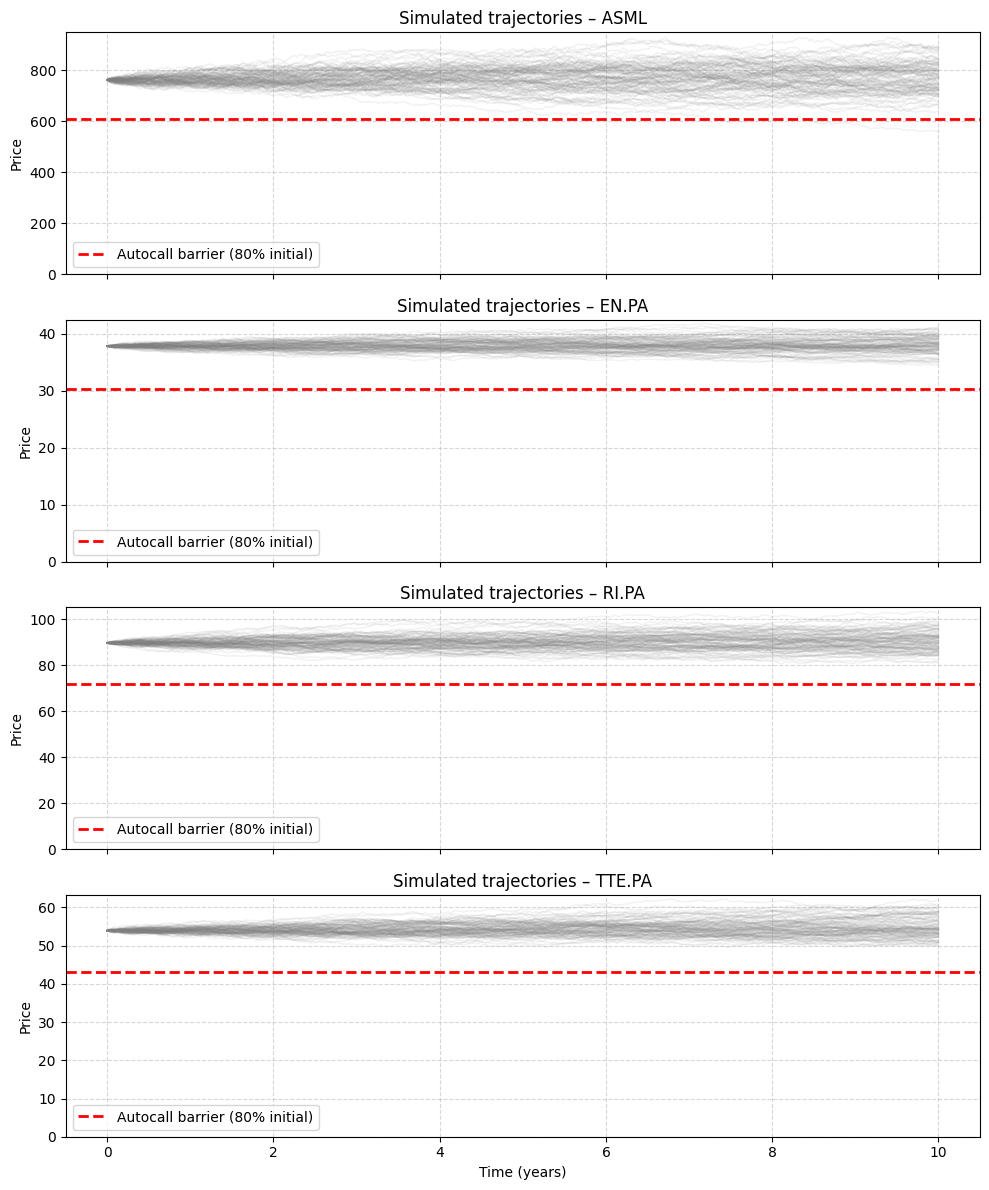

In [905]:
num_paths_to_plot = 100
num_assets = len(S0)

fig, axes = plt.subplots(num_assets, 1, figsize=(10, 3 * num_assets), sharex=True)

time = np.linspace(0, N_steps * dt, N_steps + 1)

for d_idx in range(num_assets):
    ax = axes[d_idx] if num_assets > 1 else axes
    for i in range(num_paths_to_plot):
        ax.plot(time, all_paths[i, :, d_idx], lw=1, alpha=0.1, color='gray')
    ax.set_title(f"Simulated trajectories – {asset_names[d_idx]}")
    ax.set_ylabel("Price")
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    
    barrier_level = 0.8 * S0[d_idx]
    ax.axhline(y=barrier_level, color='red', linestyle='--', linewidth=2, label=f'Autocall barrier (80% initial)')
    ax.legend()
    
    ax.set_ylim(bottom=0)  # Échelle verticale commence à 0

axes[-1].set_xlabel("Time (years)")
plt.tight_layout()
plt.show()


In [906]:
volat

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.0278184 , 0.01227372, 0.0152693 , 0.01573823],
        [0.02778468, 0.01227394, 0.01528526, 0.0157242 ],
        ...,
        [0.02782698, 0.01223841, 0.01532765, 0.01576488],
        [0.02780605, 0.01225245, 0.01532438, 0.01577752],
        [0.02778673, 0.01225339, 0.01532483, 0.01578979]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.0278184 , 0.01227372, 0.0152693 , 0.01573823],
        [0.02778468, 0.01227394, 0.01528526, 0.0157242 ],
        ...,
        [0.02782698, 0.01223841, 0.01532765, 0.01576488],
        [0.02780605, 0.01225245, 0.01532438, 0.01577752],
        [0.02778673, 0.01225339, 0.01532483, 0.01578979]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.0278184 , 0.01227372, 0.0152693 , 0.01573823],
        [0.02778468, 0.01227394, 0.01528526, 0.0157242 ],
        ...,
        [0.02782698, 0.01223841, 0.01532765, 0.01576488],
        [0.02780605, 0.012252

# Pricing

⚠️ We need to take into account that the Autocall barrier percentage is changing with respect to time. 

In [907]:
def calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates):
    """
    Calculate cash flows for an autocallable product using normalized asset paths.

    Parameters:
    - normalized_paths: np.ndarray (num_paths, num_steps, num_assets), where all paths start at 1.0
    - interest_barrier: float, e.g. 0.9
    - autocall_barriers: list of float, e.g. [0.95, 0.95, ...]
    - knock_in_barrier: float, e.g. 0.6
    - interest_rate: float, e.g. 0.0255 for 2.55%
    - observation_dates: list of integers (indices in the time axis)

    Returns:
    - np.ndarray of shape (num_paths,) with the cash flow per path
    """
    num_paths = normalized_paths.shape[0]
    cash_flows = np.zeros(num_paths)

    autocall_flag = 0

    for path_idx in range(num_paths):
        path = normalized_paths[path_idx, :, :]
        path_cash_flow = 0

        for date_idx, obs_date in enumerate(observation_dates):
            prices = path[obs_date, :]
            worst_perf = np.min(prices)

            
            # 1. If worst performance is above the interest barrier, pay interest for all past quaters
            if worst_perf >= interest_barrier:
                path_cash_flow = interest_rate * 1000  * (date_idx +1)


            # 2. Check if autocall is triggered
            if worst_perf >= autocall_barriers[date_idx]:
                path_cash_flow += 1000
                autocall_flag = 1
                break  # Autocall triggered → early exit

        # 3. If not autocalled, check if knock-in barrier is breached
        if autocall_flag == 0:
            final_prices = path[-1, :]
            worst_final = np.min(final_prices)

            if worst_final >= knock_in_barrier:
                path_cash_flow += 1000
            else:
                path_cash_flow += worst_final * 1000  # capital loss

        cash_flows[path_idx] = path_cash_flow

    return cash_flows

In [908]:
# Define the autocall barriers according to the document
autocall_barriers = [
    0.85, 0.85, 0.85,  # First four quarters
    0.81, 0.81, 0.81, 0.81,  # Next four quarters
    0.77, 0.77, 0.77, 0.77,  # Following four quarters
    0.73, 0.73, 0.73, 0.73,  # And so on...
    0.69, 0.69, 0.69, 0.69,
    0.65, 0.65, 0.65, 0.65,
    0.61, 0.61, 0.61, 0.61,
    0.60, 0.60, 0.60, 0.60,
    0.60, 0.60, 0.60, 0.60,
    0.60, 0.60, 0.60, 0.60
]

# Example usage
num_paths = 1000
num_steps = 252 * 10  # 10 years of daily data
num_underlyings = 4  # As per the document: TOTALENERGIES SE, ASML HOLDING NV, BOUYGUES SA, PERNOD RICARD SA
underlying_paths = all_paths
normalized_paths = underlying_paths / underlying_paths[:, 0, :][:, np.newaxis, :]
log_returns = np.log(normalized_paths[:, 1:, :] / normalized_paths[:, :-1, :])
vol_per_asset = np.std(log_returns, axis=(0, 1)) / np.sqrt(dt)  # annualisée

print("Volatilité annualisée simulée par actif :", vol_per_asset)



interest_barrier = 0.6
knock_in_barrier = 0.3
interest_rate = 0.0225  # 2.25%
observation_dates = np.arange(63, normalized_paths.shape[1], 63)


cash_flows = calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates)
print("Mean :", cash_flows.mean())

type(cash_flows)

Volatilité annualisée simulée par actif : [0.02776616 0.01224644 0.01529483 0.01571661]
Mean : 1022.5


numpy.ndarray

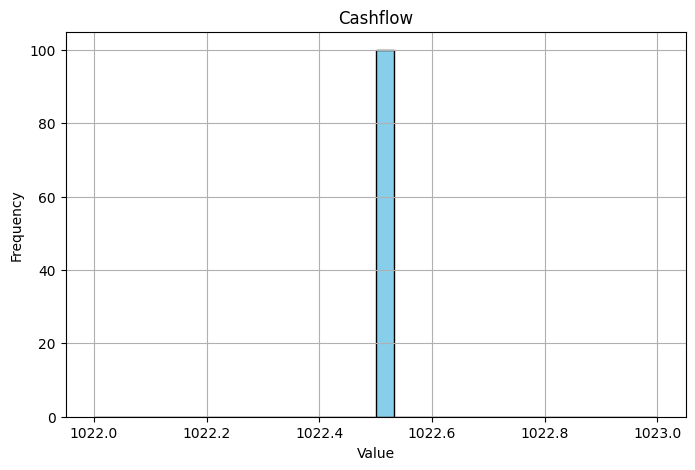

In [909]:
# Tracé de l'histogramme
plt.figure(figsize=(8, 5))
plt.hist(cash_flows, bins=30, color='skyblue', edgecolor='black')
plt.title("Cashflow")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [910]:
finals = normalized_paths[:, -1, :]
worst_finals = np.min(finals, axis=1)
print("Worst final mean:", np.mean(worst_finals))
print("Worst final < 0.6 (knock-in) ratio:", np.mean(worst_finals < 0.6))


Worst final mean: 0.9616655682012548
Worst final < 0.6 (knock-in) ratio: 0.0


In [911]:
final_prices = normalized_paths[:, -1, :]  # shape (num_paths, num_assets)

print("Moyennes finales par actif :", final_prices.mean(axis=0))
print("Écarts-types finaux par actif :", final_prices.std(axis=0))
print("Quantiles finaux par actif :", np.quantile(final_prices, [0.05, 0.5, 0.95], axis=0))


Moyennes finales par actif : [1.0110719  1.00591241 1.00884251 1.01636164]
Écarts-types finaux par actif : [0.08120335 0.03919012 0.0489963  0.05132545]
Quantiles finaux par actif : [[0.88433848 0.93811128 0.93907192 0.94047898]
 [1.01213268 1.00694711 1.00691055 1.00695262]
 [1.15121689 1.07154319 1.08801378 1.10630755]]
